In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,r2_score
from xgboost import XGBClassifier
from imblearn.over_sampling import RandomOverSampler

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/foreseeing-traveler-contentment/sample_submission.csv
/kaggle/input/foreseeing-traveler-contentment/train.csv
/kaggle/input/foreseeing-traveler-contentment/test.csv


# **Data Pre-Processing and EDA**

Loading the dataset and removing duplicate rows

In [2]:
df=pd.read_csv("/kaggle/input/foreseeing-traveler-contentment/train.csv")
df=df.drop_duplicates()
df=df.set_index('id')
df

,Unnamed: 0,Gender,Traveler Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,contentment
id,,,,,,,,,,,,,,,,,,,,,
70172,0,Male,Loyal Traveler,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,discontent
5047,1,Male,disloyal Traveler,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,discontent
110028,2,Female,Loyal Traveler,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,content
24026,3,Female,Loyal Traveler,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,discontent
119299,4,Male,Loyal Traveler,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,content
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94171,103899,Female,disloyal Traveler,23,Business travel,Eco,192,2,1,2,...,2,3,1,4,2,3,2,3,0.0,discontent
73097,103900,Male,Loyal Traveler,49,Business travel,Business,2347,4,4,4,...,5,5,5,5,5,5,4,0,0.0,content
68825,103901,Male,disloyal Traveler,30,Business travel,Business,1995,1,1,1,...,4,3,2,4,5,5,4,7,14.0,discontent


Getting the null value percentages of each column

In [3]:
null_value_percentages=(df.isna().sum()/df.shape[0])*100
null_value_percentages=null_value_percentages[null_value_percentages>0]
null_value_percentages

Arrival Delay in Minutes    0.298352
dtype: float64

Histplots for each column to observe the distribution

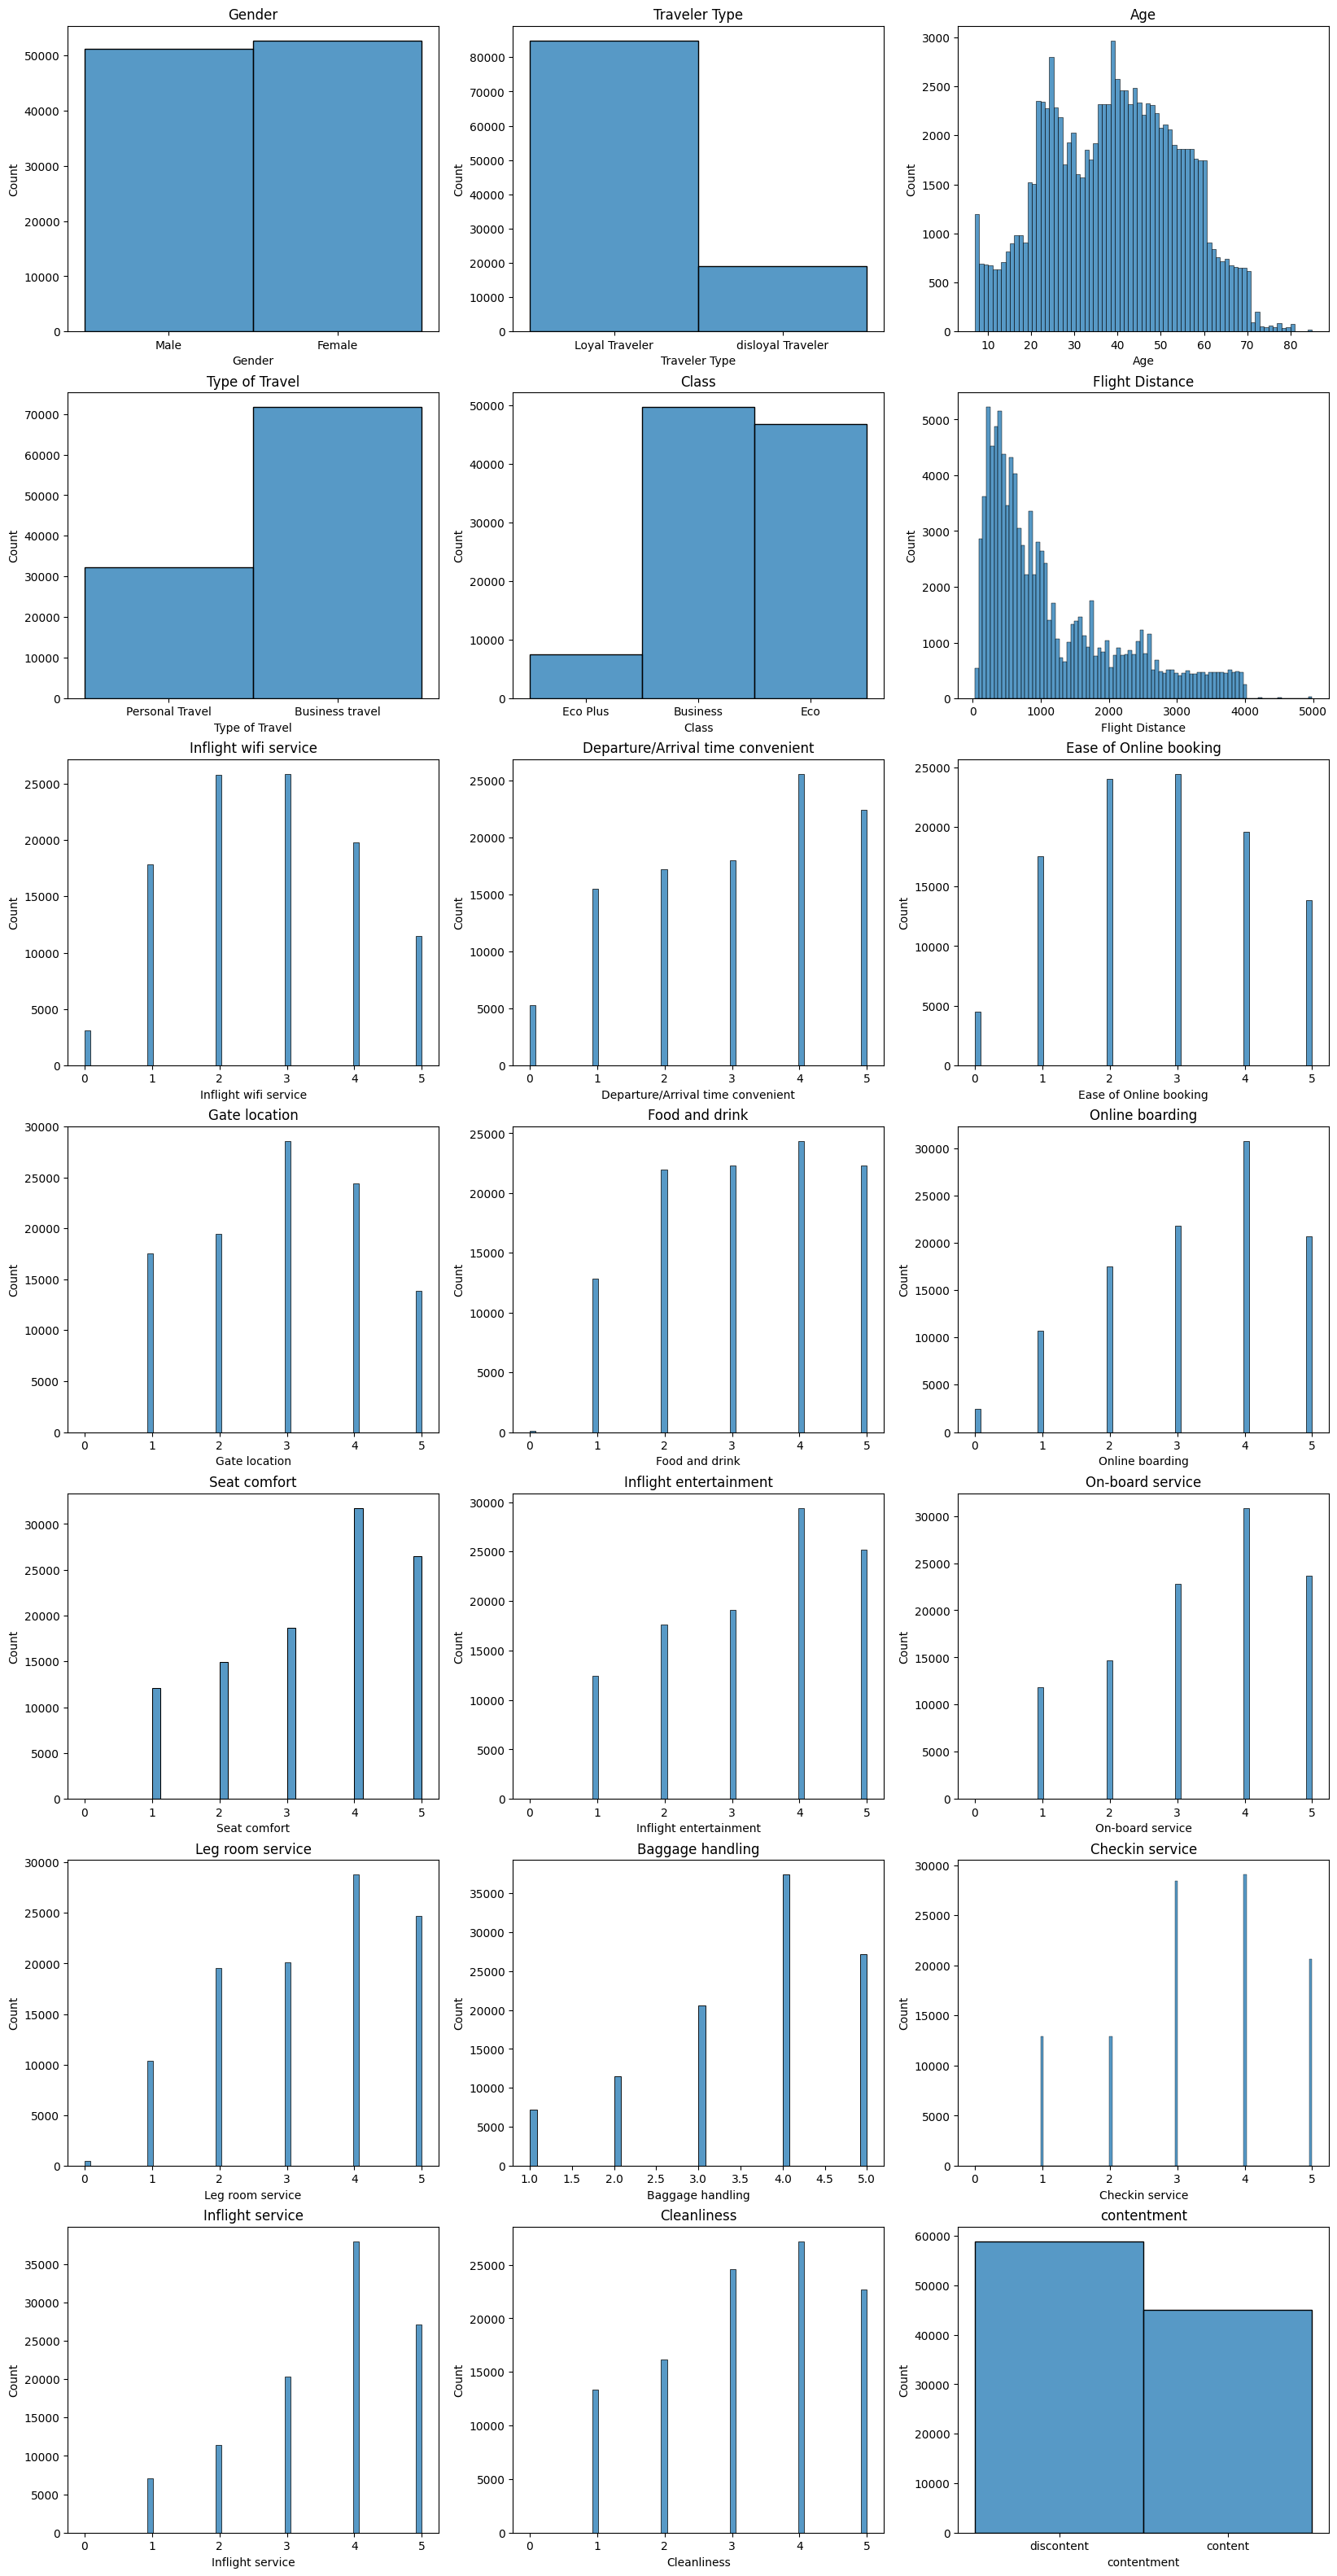

In [4]:
num_rows = 7
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 40))
lists=["Unnamed: 0",'id','Departure Delay in Minutes', 'Arrival Delay in Minutes']
cols=[item for item in df.columns if item not in lists]
for i, order in enumerate(cols):
    row = i // num_cols
    col = i % num_cols

    ax = axes[row, col]
    ax.set_title(f"{order}")
    sns.histplot(ax=ax,data=df[order])
    
plt.show()

Scatter plot for the arrival and departure delay columns. Most of the values are concentrated in the 0-200 minute range.

<Axes: xlabel='id', ylabel='Arrival Delay in Minutes'>

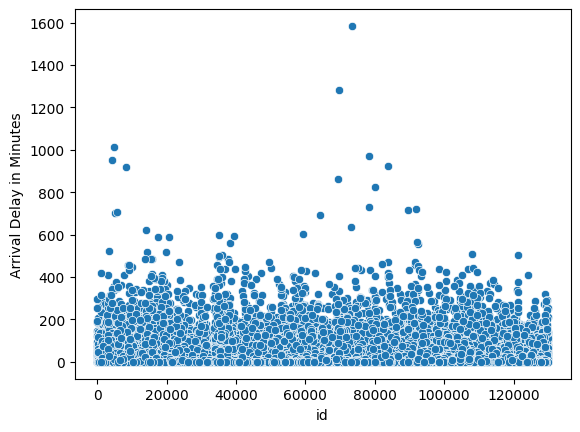

In [5]:
sns.scatterplot(df['Arrival Delay in Minutes'])

<Axes: xlabel='id', ylabel='Departure Delay in Minutes'>

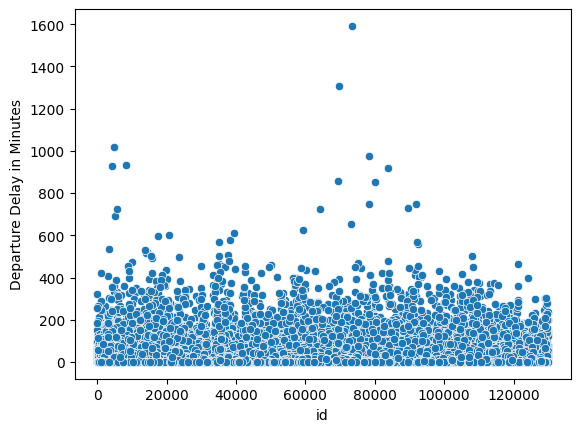

In [6]:
sns.scatterplot(df['Departure Delay in Minutes'])

Finding columns which need encoding 

In [7]:
ColToLabel=[]
for col in df.columns:
    if(df[col].dtypes=='object' and col!="contentment"):
        ColToLabel.append(col)
ColToLabel

['Gender', 'Traveler Type', 'Type of Travel', 'Class']

One-hot encoding done on the columns which have strings as values.

In [8]:
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(df[ColToLabel])

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
encoded_column_names = []
for i, column in enumerate(ColToLabel):
    categories = encoder.categories_[i]
    encoded_column_names.extend([column + '_' + str(category) for category in categories])

In [10]:
df.drop(ColToLabel, axis=1, inplace=True)
df[encoded_column_names] = encoded_columns

Used Label Encoder for the 'contentment' category.

In [11]:
le=LabelEncoder()
df['contentment']=le.fit_transform(df['contentment'])
df

,Unnamed: 0,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,contentment,Gender_Female,Gender_Male,Traveler Type_Loyal Traveler,Traveler Type_disloyal Traveler,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
70172,0,13,460,3,4,3,1,5,3,5,...,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5047,1,25,235,3,2,3,3,1,3,1,...,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
110028,2,26,1142,2,2,2,2,5,5,5,...,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
24026,3,25,562,2,5,5,5,2,2,2,...,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
119299,4,61,214,3,3,3,3,4,5,5,...,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94171,103899,23,192,2,1,2,3,2,2,2,...,1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
73097,103900,49,2347,4,4,4,4,2,4,5,...,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
68825,103901,30,1995,1,1,1,3,4,1,5,...,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


Filling the null values with the mean of the corresponding column.

In [12]:
for col in null_value_percentages.keys():
    df[col]=df[col].fillna(value=df[col].mean())
df

,Unnamed: 0,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,contentment,Gender_Female,Gender_Male,Traveler Type_Loyal Traveler,Traveler Type_disloyal Traveler,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
70172,0,13,460,3,4,3,1,5,3,5,...,1,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
5047,1,25,235,3,2,3,3,1,3,1,...,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
110028,2,26,1142,2,2,2,2,5,5,5,...,0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
24026,3,25,562,2,5,5,5,2,2,2,...,1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
119299,4,61,214,3,3,3,3,4,5,5,...,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94171,103899,23,192,2,1,2,3,2,2,2,...,1,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
73097,103900,49,2347,4,4,4,4,2,4,5,...,0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
68825,103901,30,1995,1,1,1,3,4,1,5,...,1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0


Plotting boxplots to detect outliers in each feature. Traveler Type and Checking Service need outlier removal

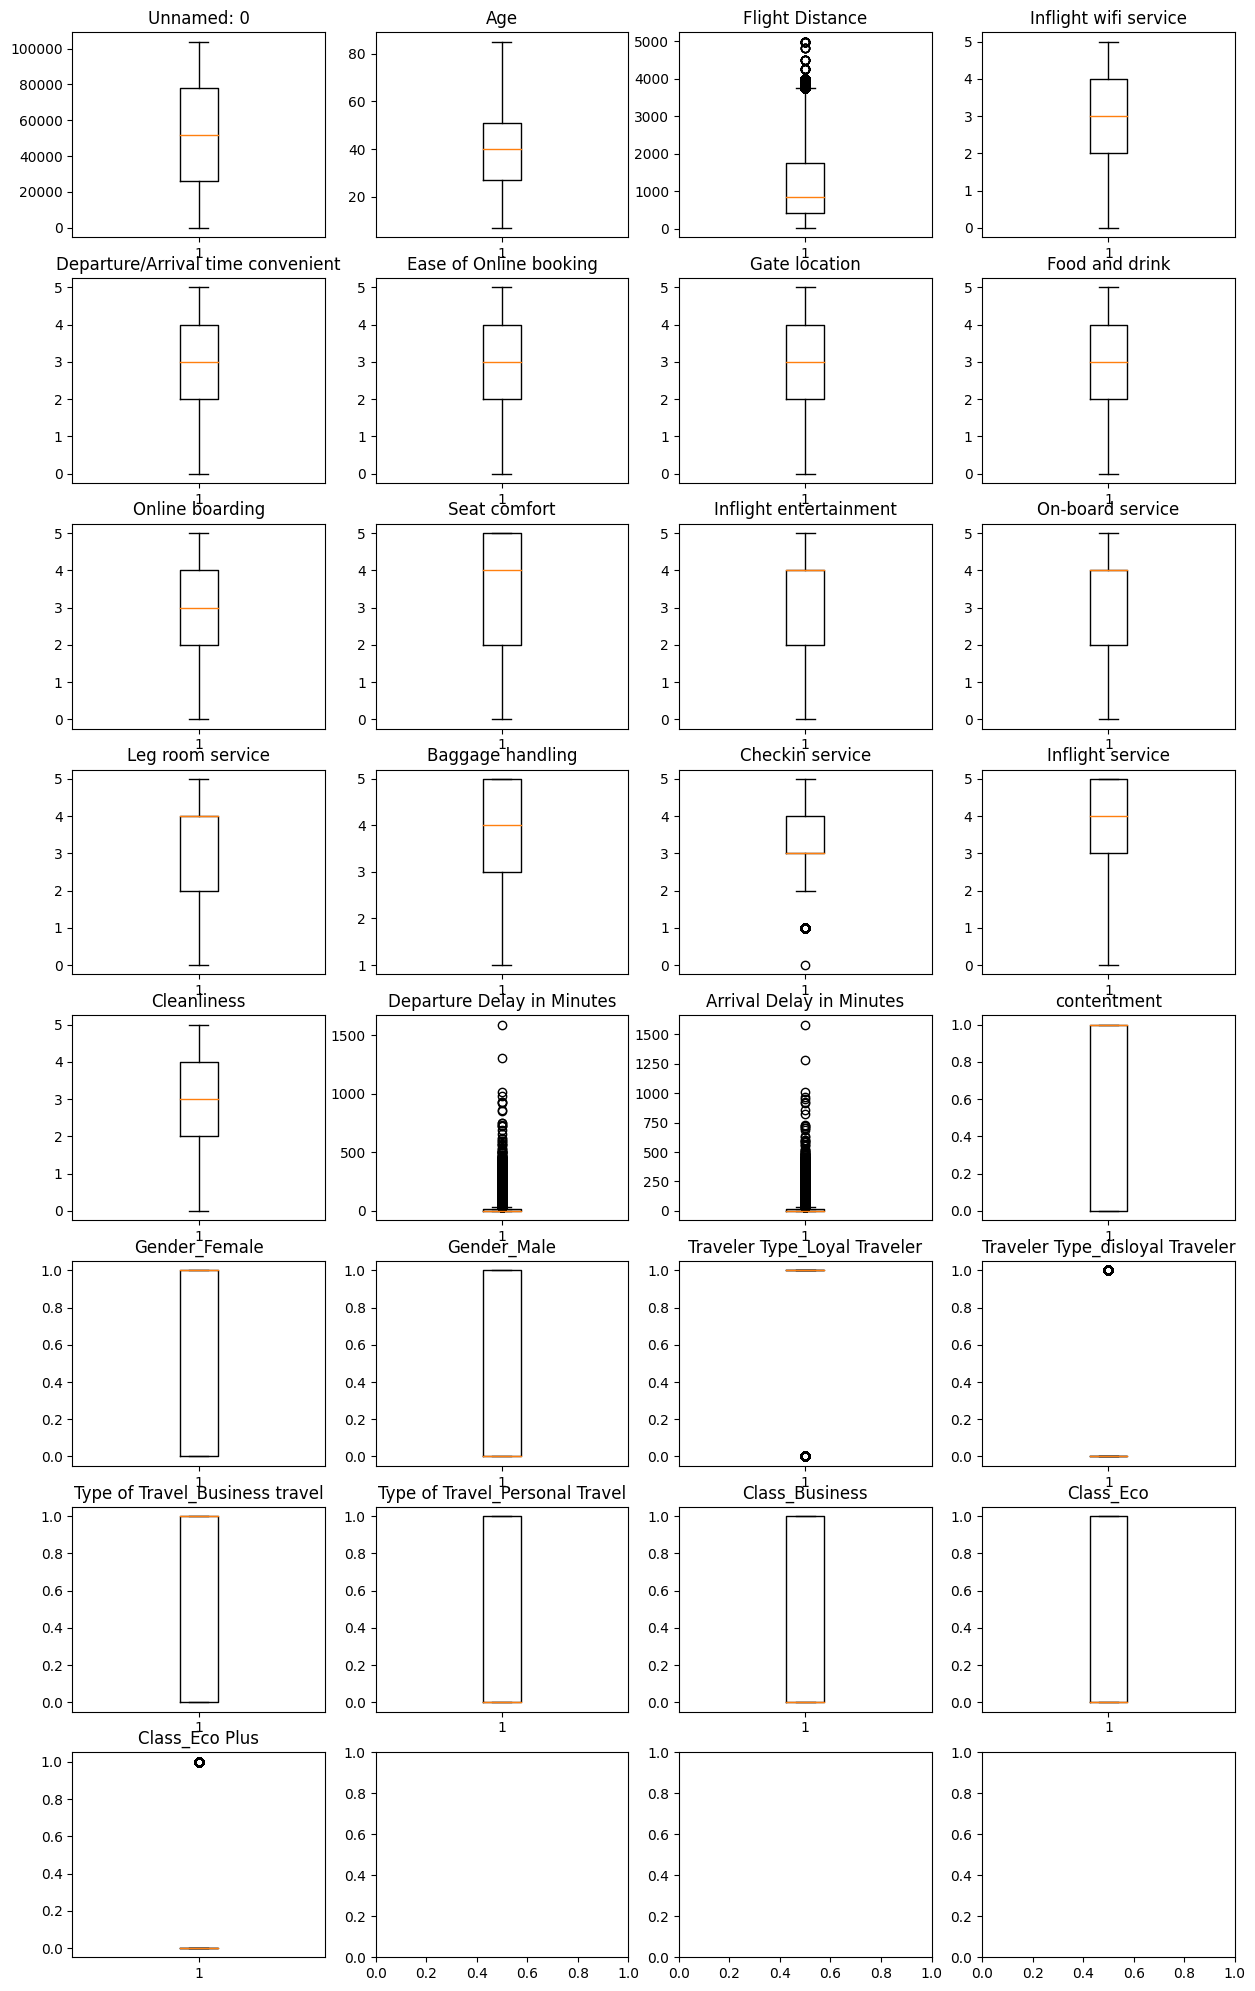

In [13]:
num_rows = 8
num_cols = 4
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 25))

for i, order in enumerate(df.columns):
    row = i // num_cols
    col = i % num_cols
    
    ax = axes[row, col]
    ax.set_title(f"{order}")
    
    ax.boxplot(df[order])
    
plt.show()
    

In [14]:
class outlierremoval:
	def __init__(self, col):
		q1 = col.quantile(0.25)
		q3 = col.quantile(0.75)
		inter_quartile_range=q3-q1
		self.upper_whisker=q3+inter_quartile_range*1.5
		self.lower_whisker=q1-inter_quartile_range*1.5
  
	def remove(self, row):
		if(row<=self.upper_whisker and row>=self.lower_whisker):
			return row
		elif row < self.lower_whisker:
			return self.lower_whisker
		else:
			return self.upper_whisker

Removing outliers form the 'Flight Distance' and 'Checkin service' columns as observed in the boxplot diagram

In [15]:
remover = outlierremoval(df["Flight Distance"])
df["Flight Distance"]=df["Flight Distance"].apply(remover.remove)
remover=outlierremoval(df["Checkin service"])
df["Checkin service"]=df["Checkin service"].apply(remover.remove)

Plotting the heatmap to get the correlation between the columns. Arrival delay and departure delay have very high correlation and based on the above EDA, we see that most of the values are between 0-200 minutes. 

<Axes: >

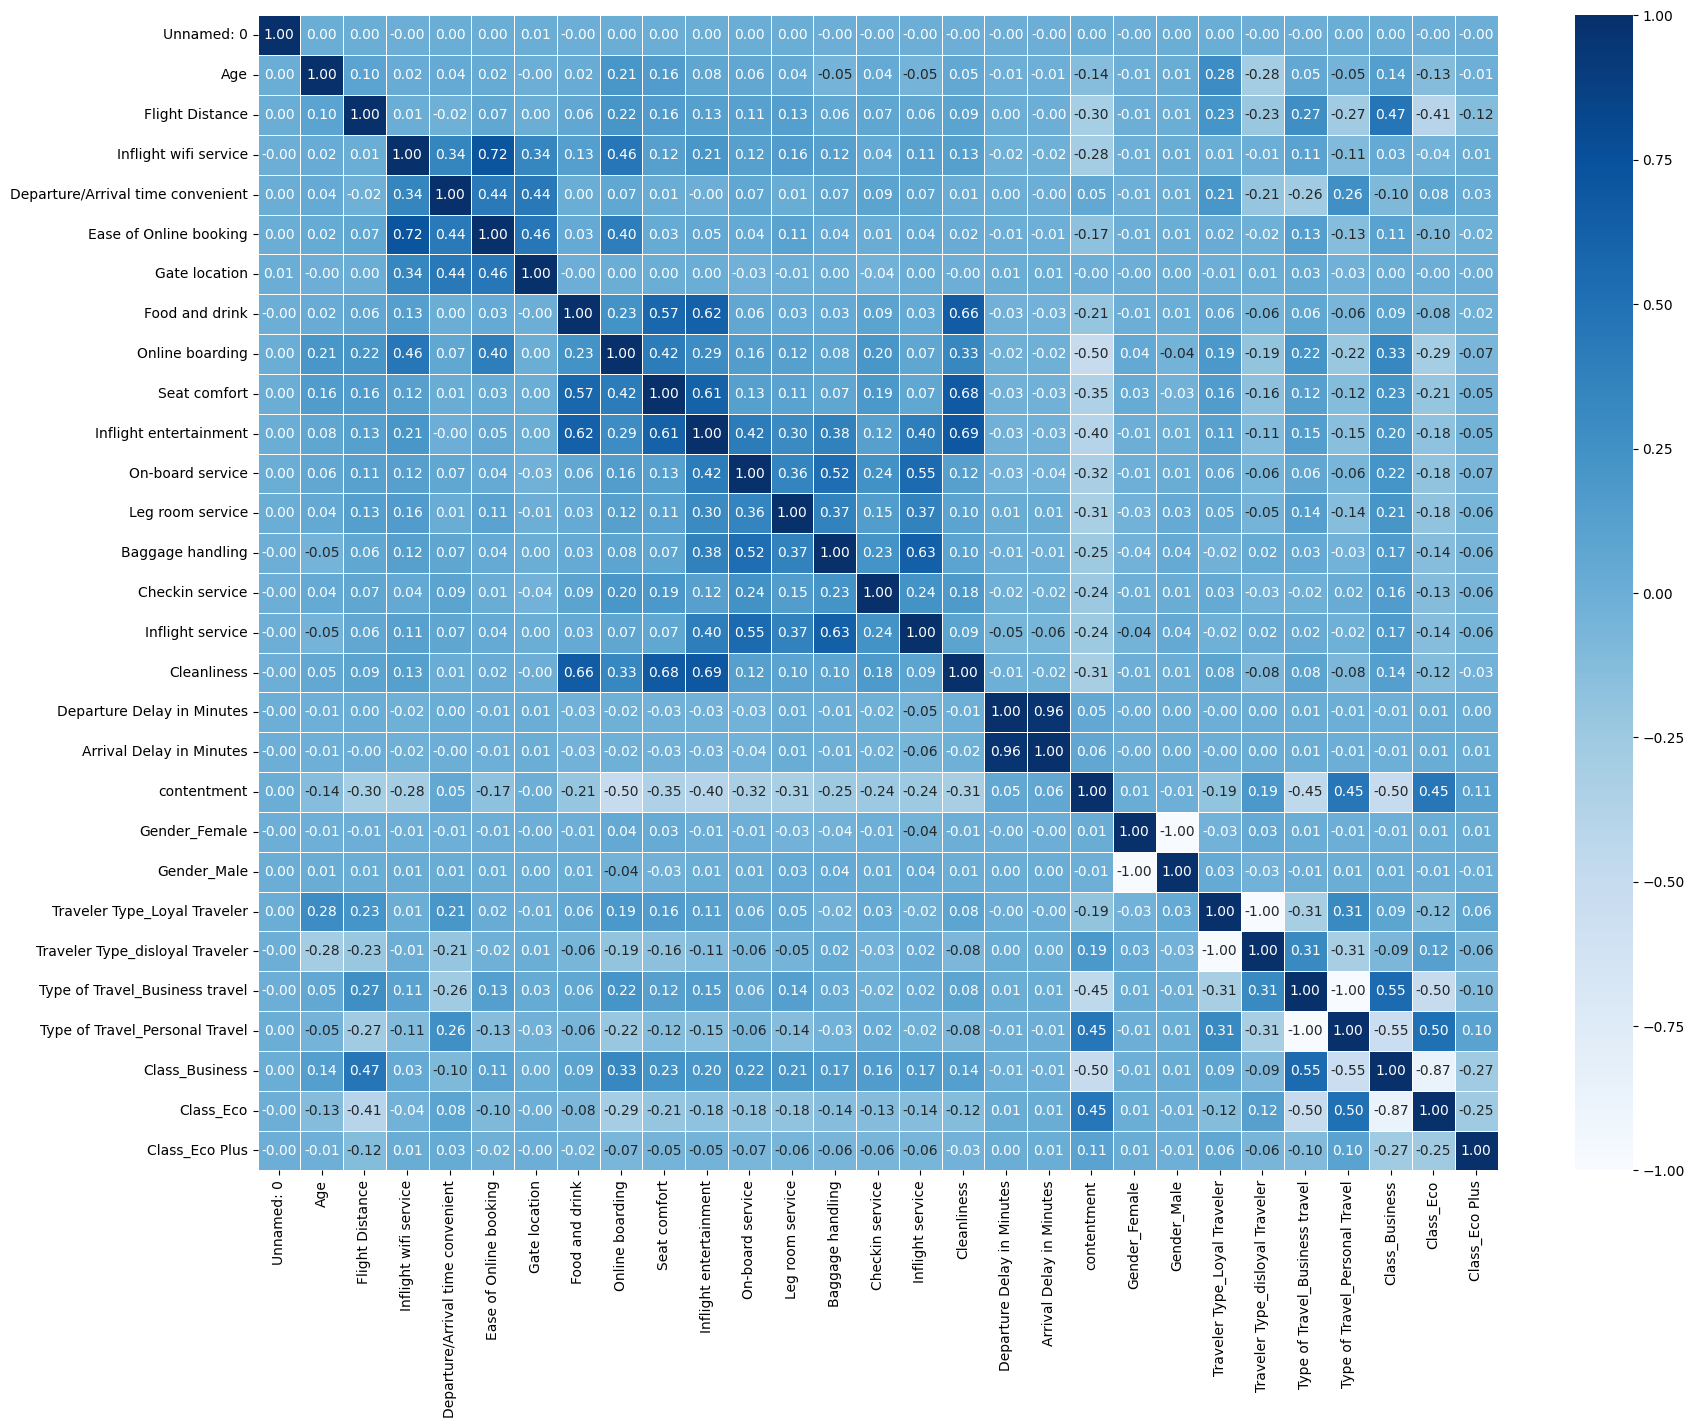

In [16]:
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(numeric_only=True),annot=True,fmt='.2f',annot_kws={'size': 10},linewidths=0.5,cmap='Blues')

X and Y columns, where the columns mentioned above are dropped.

In [17]:
X=df.drop(['contentment','Unnamed: 0'],axis=1)
X=X.drop(['Departure Delay in Minutes', 'Arrival Delay in Minutes'],axis=1)
Y=df[['contentment']]
X.shape,Y

((103904, 25),
         contentment
 id                 
 70172             1
 5047              1
 110028            0
 24026             1
 119299            0
 ...             ...
 94171             1
 73097             0
 68825             1
 54173             1
 62567             1
 
 [103904 rows x 1 columns])

Normalizing the columns using StandardScaler.

In [18]:
from sklearn.preprocessing import StandardScaler
for col in X.columns:
    X[col]=StandardScaler().fit_transform(X[col].to_numpy().reshape(-1,1).astype(np.float32))

The given dataset has more rows where in the 'contentment' column, there are more 'discontent', which can lead to more bias for discontent, hence used the RandomOverSampler to get a dataset with same 'discontent' and 'content' values

In [19]:
# ROS=RandomOverSampler(random_state=42)
# X,Y=ROS.fit_resample(X,Y)
# sns.histplot(data=Y)
# Y

Splitting the data to train and validation.

In [20]:
from sklearn.model_selection import train_test_split 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train,Y_train

(             Age  Flight Distance  Inflight wifi service  \
 id                                                         
 37164   1.298077        -0.141818               0.956691   
 43436   0.041039        -0.439353               0.956691   
 5306    1.695037        -0.812788              -0.549533   
 79161   2.025836         1.065522               0.203579   
 33333  -0.951360         0.173932              -0.549533   
 ...          ...              ...                    ...   
 118014 -0.025121        -0.555735               0.203579   
 88599  -1.480640        -0.546627               0.203579   
 36593   0.437998         0.010997              -1.302646   
 38896  -0.157441        -0.876546               1.709804   
 52111  -1.679119        -0.845173               0.956691   
 
         Departure/Arrival time convenient  Ease of Online booking  \
 id                                                                  
 37164                            1.271880                0.88861

# Training ML Model

Training the dataset on different models, i.e Random Forest, Logistic Regression, XGBoost and KNN

In [21]:
rfc=RandomForestClassifier(random_state=42)
rfc.fit(X_train,Y_train)

/tmp/ipykernel_32/1520738215.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train,Y_train)


RandomForestClassifier(random_state=42)

In [22]:
knn=KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


KNeighborsClassifier()

In [23]:
model=LogisticRegression(max_iter=4000);
model.fit(X_train,Y_train)

/opt/conda/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(max_iter=4000)

In [24]:
xgboost_mode=XGBClassifier()
xgboost_mode.fit(X_train,Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Displaying the accuracy score of each model on the validation and train data respection.(validation score, train score)

Logistic Regression

In [25]:
Y_pred1=model.predict(X_test)
score=accuracy_score(Y_test, Y_pred1)
score , accuracy_score(Y_train, model.predict(X_train))

(0.8765699436985708, 0.8740059911215909)

Random Forest

In [26]:
Y_pred=rfc.predict(X_test)
score=accuracy_score(Y_test, Y_pred)
score , accuracy_score(Y_train, rfc.predict(X_train))

(0.9629469226697464, 0.9999879696353596)

XG Boost

In [27]:
Y_pred_Xgv=xgboost_mode.predict(X_test)
score=accuracy_score(Y_test,Y_pred_Xgv)
score , accuracy_score(Y_train, xgboost_mode.predict(X_train))

(0.962850680910447, 0.9763843942109885)

KNN

In [28]:
Y_predknn=knn.predict(X_test)
score=accuracy_score(Y_test, Y_predknn)
score , accuracy_score(Y_train, knn.predict(X_train))

(0.9272412299696838, 0.9467536061018009)

# Preprocessing, EDA and Predictions on Test Data 

In [29]:
test_data=pd.read_csv('/kaggle/input/foreseeing-traveler-contentment/test.csv')
test_data=test_data.set_index('id')
test_data

,Unnamed: 0,Gender,Traveler Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
id,,,,,,,,,,,,,,,,,,,,,
19556,0,Female,Loyal Traveler,52,Business travel,Eco,160,5,4,3,...,3,5,5,5,5,2,5,5,50,44.0
90035,1,Female,Loyal Traveler,36,Business travel,Business,2863,1,1,3,...,5,4,4,4,4,3,4,5,0,0.0
12360,2,Male,disloyal Traveler,20,Business travel,Eco,192,2,0,2,...,2,2,4,1,3,2,2,2,0,0.0
77959,3,Male,Loyal Traveler,44,Business travel,Business,3377,0,0,0,...,4,1,1,1,1,3,1,4,0,6.0
36875,4,Female,Loyal Traveler,49,Business travel,Eco,1182,2,3,4,...,2,2,2,2,2,4,2,4,0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78463,25971,Male,disloyal Traveler,34,Business travel,Business,526,3,3,3,...,4,4,3,2,4,4,5,4,0,0.0
71167,25972,Male,Loyal Traveler,23,Business travel,Business,646,4,4,4,...,4,4,4,5,5,5,5,4,0,0.0
37675,25973,Female,Loyal Traveler,17,Personal Travel,Eco,828,2,5,1,...,2,2,4,3,4,5,4,2,0,0.0


In [30]:
encoder = OneHotEncoder(sparse=False)
test_encoded_columns = encoder.fit_transform(test_data[ColToLabel])
test_data.drop(ColToLabel, axis=1, inplace=True)
test_data[encoded_column_names] = test_encoded_columns

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
remover = outlierremoval(test_data["Flight Distance"])
test_data["Flight Distance"]=test_data["Flight Distance"].apply(remover.remove)
remover=outlierremoval(test_data["Checkin service"])
test_data["Checkin service"]=test_data["Checkin service"].apply(remover.remove)

In [32]:
test_data['Arrival Delay in Minutes']=test_data['Arrival Delay in Minutes'].fillna(value=test_data['Arrival Delay in Minutes'].mean())
Xt=test_data
Xt

,Unnamed: 0,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,...,Arrival Delay in Minutes,Gender_Female,Gender_Male,Traveler Type_Loyal Traveler,Traveler Type_disloyal Traveler,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
19556,0,52,160.0,5,4,3,4,3,4,3,...,44.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
90035,1,36,2863.0,1,1,3,1,5,4,5,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
12360,2,20,192.0,2,0,2,4,2,2,2,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
77959,3,44,3377.0,0,0,0,2,3,4,4,...,6.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
36875,4,49,1182.0,2,3,4,3,4,1,2,...,20.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78463,25971,34,526.0,3,3,3,1,4,3,4,...,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
71167,25972,23,646.0,4,4,4,4,4,4,4,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
37675,25973,17,828.0,2,5,1,5,2,1,2,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [33]:
X1=Xt.drop(['Unnamed: 0','Departure Delay in Minutes', 'Arrival Delay in Minutes'],axis=1)

for col in X1.columns:
    X1[col]=StandardScaler().fit_transform(X1[col].to_numpy().reshape(-1,1).astype(np.float32))
    
X1

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Cleanliness,Gender_Female,Gender_Male,Traveler Type_Loyal Traveler,Traveler Type_disloyal Traveler,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
id,,,,,,,,,,,,,,,,,,,,,
19556,0.817887,-1.041795,1.703853,0.621641,0.172143,0.797831,-0.161739,0.544692,-0.340303,1.227138,...,1.298998,0.985932,-0.985932,0.476040,-0.476040,0.663378,-0.663378,-0.962736,1.116370,-0.282275
90035,-0.239238,1.691566,-1.291598,-1.334871,0.172143,-1.542065,1.340348,0.544692,1.174774,0.479907,...,1.298998,0.985932,-0.985932,0.476040,-0.476040,0.663378,-0.663378,1.038707,-0.895761,-0.282275
12360,-1.296363,-1.009435,-0.542735,-1.987042,-0.535609,0.797831,-0.912783,-0.930768,-1.097842,-1.014556,...,-0.974927,-1.014269,1.014269,-2.100665,2.100665,0.663378,-0.663378,-0.962736,1.116370,-0.282275
77959,0.289325,2.211339,-2.040461,-1.987042,-1.951113,-0.762100,-0.161739,0.544692,0.417235,-1.761787,...,0.541023,-1.014269,1.014269,0.476040,-0.476040,0.663378,-0.663378,1.038707,-0.895761,-0.282275
36875,0.619676,-0.008315,-0.542735,-0.030530,0.879895,0.017866,0.589304,-1.668498,-1.097842,-1.014556,...,0.541023,0.985932,-0.985932,0.476040,-0.476040,0.663378,-0.663378,-0.962736,1.116370,-0.282275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78463,-0.371378,-0.671684,0.206127,-0.030530,0.172143,-1.542065,0.589304,-0.193038,0.417235,0.479907,...,0.541023,-1.014269,1.014269,-2.100665,2.100665,0.663378,-0.663378,1.038707,-0.895761,-0.282275
71167,-1.098152,-0.550336,0.954990,0.621641,0.879895,0.797831,0.589304,0.544692,0.417235,0.479907,...,0.541023,-1.014269,1.014269,0.476040,-0.476040,0.663378,-0.663378,1.038707,-0.895761,-0.282275
37675,-1.494573,-0.366292,-0.542735,1.273812,-1.243361,1.577797,-0.912783,-1.668498,-1.097842,-1.014556,...,-0.974927,0.985932,-0.985932,0.476040,-0.476040,-1.507435,1.507435,-0.962736,1.116370,-0.282275


Getting the prediction on the test data using the random forest model which is trained with the entire training dataset.

In [34]:
rfcfinal=RandomForestClassifier(random_state=42)
rfcfinal.fit(X,Y)
Y_Prediction=rfcfinal.predict(X1)
Y_Prediction

/tmp/ipykernel_32/217167649.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfcfinal.fit(X,Y)


array([0, 0, 1, ..., 1, 0, 1])

In [35]:
for col in test_data.columns:
    test_data=test_data.drop([col],axis=1)
test_data.insert(0,'contentment',Y_Prediction)

In [36]:
test_data['contentment']=test_data['contentment'].replace(1,'neutral or discontent')
test_data['contentment']=test_data['contentment'].replace(0,'content')
test_data

,contentment
id,
19556,content
90035,content
12360,neutral or discontent
77959,content
36875,neutral or discontent
...,...
78463,neutral or discontent
71167,content
37675,neutral or discontent


Creating the csv file with the final results.

In [37]:
test_data.to_csv('submission.csv')